In [ ]:
!chcp 65001
# !wget -O news.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1hIVVpBqM6VU4n3ERkKq4tFaH4sKN0Hab"
# !unzip news.zip

Active code page: 65001


In [1]:
import requests
import zipfile
import io

url = "https://drive.google.com/uc?export=download&id=1hIVVpBqM6VU4n3ERkKq4tFaH4sKN0Hab"
response = requests.get(url, verify=False)  # verify=False если проблемы с SSL

with open("news.zip", "wb") as f:
    f.write(response.content)

with zipfile.ZipFile("news.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.usercontent.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [1]:
!pip install torchtext==0.6.0
!pip install sacremoses==0.0.5

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

In [3]:
import torch
import transformers

print(torch.__version__)               # 2.5.1
print(torch.cuda.is_available())

2.7.0+cu118
True


In [ ]:
!nvidia-smi

Wed May 28 21:01:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A    0C    P0            N/A  / 5001W |       0MiB /   4096MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install wandb
!wandb login f40bc28fcdb2758937b8be9acbc2bbc7b6509b6e

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Vladlen\_netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [5]:
import os
os.environ['WANDB_MODE'] = 'offline'
import wandb
# from configs import config

config = dict(
    batch_size=64,
    learning_rate=1e-5,
    weight_decay=0.01,
    epochs=30,
    d_model=256,
    n_heads=8,
    dropout_rate=0.1,
    blocks_count=4,
    b_size_train=16,
    b_size_test=32
)

# Один раз выполните при первой настройке
wandb.login()

# Запуск проекта и конфигурации
wandb.init(project="transformer-summarizer", config={
    "epochs": config['epochs'],
    "batch_size": config['b_size_train'],
    "learning_rate": config['learning_rate'],
    "model": "EncoderDecoder",
    "d_model": config['d_model'],
    "n_heads": config['n_heads'],
})

wandb: WARNING Unable to verify login in offline mode.


In [7]:
# !wandb sync "D:/05_Attention/05_Attention/seminar/wandb/offline-run-20250526_162725-2622dbq9"
!wandb sync "D:/05_Attention/05_Attention/seminar/wandb/offline-run-*"

Usage: wandb sync [OPTIONS] [PATH]...
Try 'wandb sync --help' for help.

Error: Invalid value for '[PATH]...': Path 'D:/05_Attention/05_Attention/seminar/wandb/offline-run-*' does not exist.


# Abstactive Summarization

Задача - по тексту сгенерировать выдержку из него.

Например, попробуем по новостям генерировать заголовки:

In [6]:
# !shuf -n 10 news.csv
import random

with open("news.csv", encoding="utf-8") as f:
    lines = f.readlines()

sample = random.sample(lines, 10)
print("".join(sample))

132681,"Букмекеры заявили о том, что один из поединков российской баскетбольной Суперлиги 3 (четвертый по силе дивизион национального чемпионата) может носить договорной характер. Об этом сообщает «Рейтинг Букмекеров». Речь идет о матче, состоявшемся 25 февраля между клубами «Тегас» (Динской район, Краснодарский край) и «Эльбрус» (Черкесск). Подозрение у букмекеров  вызвал необычный интерес со стороны некоторых местных профессиональных баскетболистов, которые стали единственными клиентами одной из международных контор и сделали ставки на матч. Для всех из них ставки стали первыми после регистрации на сайте. Общая сумма составила 120 тысяч рублей. Личности игроков не сообщаются. Поединок завершился победой «Тегаса» со счетом 85:80, который занимает последнее место в чемпионате. «Эльбрус» находится строчкой выше.",Букмекеры заподозрили российских баскетболистов в организации договорного матча
450169,"В России пока не планируется вводить единый внутренний и заграничный паспорт. Об этом аг

In [7]:
!pip install natasha fasttext-wheel

In [7]:
from natasha import Segmenter, Doc

segmenter = Segmenter()

def natasha_tokenize(text: str):
    doc = Doc(text)
    doc.segment(segmenter)        # разбиваем на токены
    tokens = []
    tokens = [t.text.lower() for t in doc.tokens]
    return tokens

In [8]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'
PAD_TOKEN = '<pad>'

word_field = Field(
    tokenize=natasha_tokenize,      # наша функция
    init_token=BOS_TOKEN,
    eos_token=EOS_TOKEN,
    lower=False,                    # мы уже приводим к lower()
    batch_first=True
)
fields = [('source', word_field), ('target', word_field)]

In [9]:
import pandas as pd
from tqdm.auto import tqdm

data = pd.read_csv('news.csv', delimiter=',')

examples = []
for _, row in tqdm(data.iterrows(), total=len(data)):
    source_text = word_field.preprocess(row.text)
    target_text = word_field.preprocess(row.title)
    examples.append(Example.fromlist([source_text, target_text], fields))

  0%|          | 0/74278 [00:00<?, ?it/s]

In [10]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

word_field.build_vocab(train_dataset, min_freq=7)
vocab_size = len(word_field.vocab)
print('Vocab size =', vocab_size)

# тут получаем индексы токенов
train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(16, 32), shuffle=True, device=DEVICE, sort=False
)

Train size = 63136
Test size = 11142
Vocab size = 55880


In [11]:
for batch in test_iter:
    source = batch.source  # [seq_len, batch_size]
    seq_len = source.size(1)  # длина последовательности (включая паддинги)
    batch_size = source.size(0)

    for i in range(batch_size):
        print(f'Пример {i}: длина с паддингами = {seq_len}')
    break

Пример 0: длина с паддингами = 131
Пример 1: длина с паддингами = 131
Пример 2: длина с паддингами = 131
Пример 3: длина с паддингами = 131
Пример 4: длина с паддингами = 131
Пример 5: длина с паддингами = 131
Пример 6: длина с паддингами = 131
Пример 7: длина с паддингами = 131
Пример 8: длина с паддингами = 131
Пример 9: длина с паддингами = 131
Пример 10: длина с паддингами = 131
Пример 11: длина с паддингами = 131
Пример 12: длина с паддингами = 131
Пример 13: длина с паддингами = 131
Пример 14: длина с паддингами = 131
Пример 15: длина с паддингами = 131
Пример 16: длина с паддингами = 131
Пример 17: длина с паддингами = 131
Пример 18: длина с паддингами = 131
Пример 19: длина с паддингами = 131
Пример 20: длина с паддингами = 131
Пример 21: длина с паддингами = 131
Пример 22: длина с паддингами = 131
Пример 23: длина с паддингами = 131
Пример 24: длина с паддингами = 131
Пример 25: длина с паддингами = 131
Пример 26: длина с паддингами = 131
Пример 27: длина с паддингами = 131
Пр

In [13]:
import fasttext.util, fasttext
import numpy as np
from tqdm.auto import tqdm

# если файла ещё нет, то скачает
# fasttext.util.download_model('ru', if_exists='ignore')   # выдаст cc.ru.300.bin
ft_model = fasttext.load_model('cc.ru.300.bin')
FT_DIM = ft_model.get_dimension()    # 300

word_field.build_vocab(train_dataset, min_freq=7)

vocab_size = len(word_field.vocab)
print(f"Vocab size = {vocab_size}")

vectors = np.zeros((vocab_size, FT_DIM), dtype='float32')

unk_vector = np.random.normal(scale=0.6, size=(FT_DIM,))  # на случай полного OOV

for i, token in enumerate(word_field.vocab.itos):
    if token in (BOS_TOKEN, EOS_TOKEN):
        continue
    vectors[i] = ft_model.get_word_vector(token) if token in ft_model else unk_vector

vectors[word_field.vocab.stoi[PAD_TOKEN]] = 0.0

# Привяжем к TorchText
word_field.vocab.set_vectors(stoi=word_field.vocab.stoi,
                             vectors=torch.tensor(vectors),
                             dim=FT_DIM)

Vocab size = 55880


In [51]:
embedding_layer = nn.Embedding.from_pretrained(
    embeddings=word_field.vocab.vectors,
    freeze=True,
    padding_idx=word_field.vocab.stoi[PAD_TOKEN]
)

In [14]:
for batch in train_iter:
    print(batch.source.shape)  # torch.Size([16, max_source_len])
    print(batch.target.shape)  # torch.Size([16, max_target_len])
    break

torch.Size([16, 130])
torch.Size([16, 12])


Токенизируем их. Будем использовать единый словарь для текста и заголовков.

In [12]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

word_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN, lower=True)
fields = [('source', word_field), ('target', word_field)]

In [ ]:
import pandas as pd
from tqdm.auto import tqdm

data = pd.read_csv('news.csv', delimiter=',')

examples = []
for _, row in tqdm(data.iterrows(), total=len(data)):
    source_text = word_field.preprocess(row.text)
    target_text = word_field.preprocess(row.title)
    examples.append(Example.fromlist([source_text, target_text], fields))

  0%|          | 0/74278 [00:00<?, ?it/s]

Построим датасеты:

In [ ]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

word_field.build_vocab(train_dataset, min_freq=7)
vocab_size = len(word_field.vocab)
print('Vocab size =', vocab_size)

# тут получаем индексы токенов
train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(16, 32), shuffle=True, device=DEVICE, sort=False
)

Train size = 63136
Test size = 11142
Vocab size = 55884


In [ ]:
for batch in train_iter:
    source = batch.source  # [seq_len, batch_size]
    seq_len = source.size(0)  # длина последовательности (включая паддинги)
    batch_size = source.size(1)

    for i in range(batch_size):
        print(f'Пример {i}: длина с паддингами = {seq_len}')
    break

Пример 0: длина с паддингами = 150
Пример 1: длина с паддингами = 150
Пример 2: длина с паддингами = 150
Пример 3: длина с паддингами = 150
Пример 4: длина с паддингами = 150
Пример 5: длина с паддингами = 150
Пример 6: длина с паддингами = 150
Пример 7: длина с паддингами = 150
Пример 8: длина с паддингами = 150
Пример 9: длина с паддингами = 150
Пример 10: длина с паддингами = 150
Пример 11: длина с паддингами = 150
Пример 12: длина с паддингами = 150
Пример 13: длина с паддингами = 150
Пример 14: длина с паддингами = 150
Пример 15: длина с паддингами = 150


In [15]:
for batch in train_iter:
    print(batch.source.shape)  # torch.Size([16, max_source_len])
    print(batch.source.shape)  # torch.Size([16, max_target_len])
    break

# for batch in test_loader:
#     print(batch['source'].shape)  # torch.Size([16, max_source_len])
#     print(batch['target'].shape)  # torch.Size([16, max_target_len])
#     break

torch.Size([16, 133])
torch.Size([16, 133])


## Seq2seq for Abstractive Summarization

Вообще задача не сильно отличается от машинного перевода:

![](https://image.ibb.co/jAf3S0/2018-11-20-9-42-17.png)
*From [Get To The Point: Summarization with Pointer-Generator Networks](https://arxiv.org/pdf/1704.04368.pdf)*

Тут на каждом шаге декодер подглядывает на все токены - точнее, их эмбеддинги после BiRNN.

Возникает вопрос - а зачем вообще RNN, если потом все равно будем смотреть на всё.

# Transformer

Из этой идеи - отказ от RNN - и получился Transformer.

![](https://hsto.org/webt/59/f0/44/59f04410c0e56192990801.png)  
*From Attention is all you need*

Как в случае с RNN мы на каждом шаге применяем одну и ту же операцию (ячейку LSTM) к текущему входу, так и здесь - только теперь связей между timestamp'ами нет и можно обрабатывать их почти параллельно.

*Код дальше очень сильно опирается на шикарную статью [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html).*

## Encoder

Начнем с энкодера:

![](http://jalammar.github.io/images/t/transformer_resideual_layer_norm.png)  
*From [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)*

Он представляет из себя последовательность одинаковых блоков с self-attention + полносвязными слоями.

Можно представить, что это - ячейка LSTM: она тоже применяется к каждому входу с одинаковыми весами. Разница основная в отсутствии рекуррентных связей: за счет этого энкодер может применяться одновременно ко всем входам батча.

### Positional Encoding

Нужно как-то кодировать информацию о том, в каком месте в предложении стоит токен. Авторы предложили делать так:
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$
$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$

где $(pos, i)$ - позиция в предложении и индекс в скрытом векторе размерности до $d_{model}$.

In [16]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # добавить размерность в начало
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

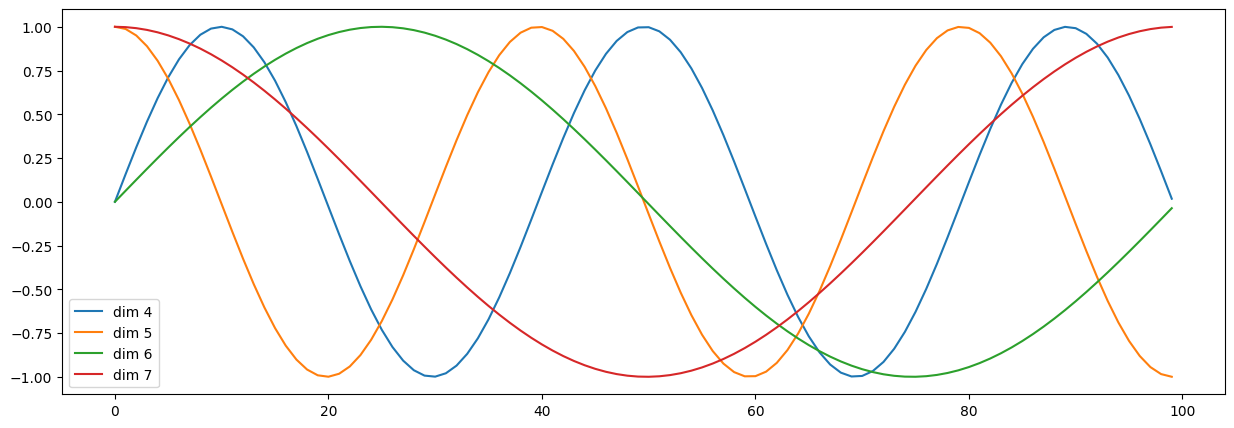

In [17]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

В итоге эмбеддинги токена получается как сумма обычного эмбеддинга и эмбеддинга позиции:  
![](http://jalammar.github.io/images/t/transformer_positional_encoding_vectors.png)  
*From [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)*

### Residual Connection

Разберем блок энкодера - повторяющейся N раз комбинации операций на первом рисунке.

Самое простое здесь - residual connection. Вместо к выходу произвольной функции $F$ прибавляется её вход
$$y = F(x) \quad \to \quad y = F(x) + x$$

Идея в том, что обычные сети сложно делать слишком глубокими - градиенты затухают. А через этот residual вход $x$ градиентам течь ничего не стоит. В итоге в картинках благодаря таким блокам получилось настакать дофига слоев и улучшить качество (см. ResNet).

Ничего не мешает нам поступить также.

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, size, dropout_rate):
        super().__init__()
        self._norm = LayerNorm(size)
        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs, sublayer):
        return inputs + self._dropout(sublayer(self._norm(inputs)))

### Layer Norm

Дополнительно применяется нормализация LayerNorm.

**Batch normalization**  
Мы вообще не разбирали, но BatchNorm работает так:
$$\mu_j = \frac{1}{m}\sum_{i=1}^{m}x_{ij} \\    \sigma_j^2 = \frac{1}{m}\sum_{i=1}^{m}(x_{ij} - \mu_j)^2 \\    \hat{x}_{ij} = \frac{x_{ij} - \mu_j}{\sqrt{\sigma_j^2 + \epsilon}}$$
$$y_{ij} = \gamma \ \hat{x}_{ij} + \beta$$

На каждом батче эти $\mu$ и $\sigma$ пересчитываются, обновляя статистики. На инференсе используются накопленные статистики.

Основной его недостаток - он плохо работает с рекуррентными сетями. Чтобы побороть это придумали:

**Layer normalization**  
А сейчас мы будем пользоваться немного другими формулами:
$$\mu_i = \frac{1}{m}\sum_{j=1}^{m}x_{ij} \\    \sigma_i^2 = \frac{1}{m}\sum_{j=1}^{m}(x_{ij} - \mu_i)^2 \\    \hat{x}_{ij} = \frac{x_{ij} - \mu_i}{\sqrt{\sigma_i^2 + \epsilon}}$$
$$y_{ij} = \gamma \ \hat{x}_{ij} + \beta$$

Разницу с ходу не видно, но она есть:
![](https://image.ibb.co/hjtuX0/layernorm.png)  
*From [Weight Normalization and Layer Normalization Explained ](http://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/)*

Если в BatchNorm статистики считаются для каждой фичи усреднением по батчу, то теперь - для каждого входа усредением по фичам.

In [19]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()

        self._gamma = nn.Parameter(torch.ones(features))
        self._beta = nn.Parameter(torch.zeros(features))
        self._eps = eps

    def forward(self, inputs):
        mean = inputs.mean(-1, keepdim=True)
        std = inputs.std(-1, keepdim=True)
        return self._gamma * (inputs - mean) / (std + self._eps) + self._beta

### Attention

Весь Transformer опирается на идею self-attention. Выглядит это так:

![](http://jalammar.github.io/images/t/transformer_self-attention_visualization.png)  
*From [Tensor2Tensor Tutorial](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)*

Эмбеддинг слова *it* строится как комбинация всех эмбеддингов предложения.

В статье придумали делать такой аттеншен:

$$\mathrm{Attention}(Q, K, V) = \mathrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Это примерно как dot-attention на прошлом занятии: запрос (**Q**uery) умножается на ключи (**K**ey) скалярно, затем берется софтмакс - получаются оценки того, насколько интересны разные таймстемпы из значений (**V**alue).

Например, $\mathrm{emb}(\text{it}) = \mathrm{Attention}(\text{it}, \ldots\text{because it was too tired}, \ldots\text{because it was too tired})$.

Только теперь ещё с параметром $\frac{1}{\sqrt{d_k}}$, где $d_k$ - это размерность ключа. Утверждается, это работает лучше при больших размерностях ключа $d_k$.

In [20]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()

        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, query, key, value, mask):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self._dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

### Multi-Head Attention

![](https://hsto.org/webt/59/f0/44/59f0440f1109b864893781.png)

Важная идея, почему attention (и, главное, self-attention) заработал - использование нескольких голов (multi-head).

Вообще, когда мы делаем attention - мы определяем похожесть ключа и запроса. Многоголовость помогает (должна) определять эту похожесть по разным критериям - синтаксически, семантически и т.д.

Например, на картинке используется две головы и одна голова смотрит на *the animal* при генерации *it*, вторая - на *tired*:

![](http://jalammar.github.io/images/t/transformer_self-attention_visualization_2.png)  
*From [Tensor2Tensor Tutorial](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)*

Применяется это таким образом:

$$\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ...,
\mathrm{head_h})W^O    \\
    \mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)$$
    
где $W^Q_i \in \mathbb{R}^{d_{model} \times d_k}, W_i^K \in \mathbb{R}^{d_{model} \times d_k}, W^V_i \in \mathbb{R}^{d_{model} \times d_v}, W^O \in \mathbb{R}^{hd_v \times d_{model}}$.

В оригинальной статье использовали $h=8$, $d_k=d_v=d_{\text{model}}/h=64$.

Процесс применения такой:
![](http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)  
*From Illustrated Transformer*

In [21]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, heads_count, d_model, dropout_rate=0.1):
        super().__init__()

        assert d_model % heads_count == 0

        self._d_k = d_model // heads_count
        self._heads_count = heads_count
        self._attention = ScaledDotProductAttention(dropout_rate)
        self._attn_probs = None

        self._w_q = nn.Linear(d_model, d_model)
        self._w_k = nn.Linear(d_model, d_model)
        self._w_v = nn.Linear(d_model, d_model)
        self._w_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)


        query = self._w_q(query).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        key = self._w_k(key).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        value = self._w_v(value).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        x, self._attn_probs = self._attention(query, key, value, mask)

        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self._heads_count * self._d_k)
        x = self._w_o(x)
        return x

### Position-wise Feed-Forward Networks

Линейный блок в энкодере выглядит так:
$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

In [22]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        return self.w_2(self.dropout(F.relu(self.w_1(inputs))))

### Encoder block

Соберем все в блок:

In [23]:
def create_attention_mask(input_ids: torch.Tensor, pad_token_id: int):
    attention_mask = (input_ids != pad_token_id).long()
    return attention_mask

In [24]:
class EncoderBlock(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, mask):
        outputs = self._self_attention_block(inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, mask))
        return self._feed_forward_block(outputs, self._feed_forward)

In [25]:
class Encoder(nn.Module):
    def __init__(self, embedding_layer, d_model, d_ff, blocks_count, heads_count, dropout_rate):
        super().__init__()
        self._emb = nn.Sequential(
            embedding_layer,
            PositionalEncoding(d_model, dropout_rate)
        )
        self.self_attns = []

        block = lambda: EncoderBlock(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

    def forward(self, inputs, mask, return_attn=False):
        inputs = self._emb(inputs)
        for block in self._blocks:
            inputs = block(inputs, mask)
        if return_attn == True:
            for block in self._blocks:
                self.self_attns.append(block._self_attn._attn_probs)

        return self._norm(inputs)

## Decoder

![](https://hsto.org/webt/59/f0/44/59f0440f7d88f805415140.png)

Блок декодера (серая часть) состоит уже из трех частей:
1. Сперва - тот же self-attention, что и в энкодере
2. Затем - стандартный attention на выходы из энкодера + текущее состояние декодера (такой же был в seq2seq with attention)
3. Наконец - feed-forward блок

Всё это, конечно, с residual связями.

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, encoder_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._encoder_attn = encoder_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        outputs = self._self_attention_block(
            inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, target_mask)
        )
        outputs = self._attention_block(
            outputs, lambda inputs: self._encoder_attn(inputs, encoder_output, encoder_output, source_mask)
        )
        return self._feed_forward_block(outputs, self._feed_forward)

In [27]:
class Decoder(nn.Module):
    def __init__(self, embedding_layer, d_model, d_ff, blocks_count, heads_count, dropout_rate):
        super().__init__()
        self._emb = nn.Sequential(
            embedding_layer,
            PositionalEncoding(d_model, dropout_rate)
        )

        self.self_attns = []

        block = lambda: DecoderLayer(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            encoder_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)
        self._out_layer = nn.Linear(d_model, vocab_size)


    def forward(self, inputs, encoder_output, source_mask, target_mask, return_attn=False):
        inputs = self._emb(inputs)
        for block in self._blocks:
            inputs = block(inputs, encoder_output, source_mask, target_mask)
        if return_attn == True:
            for block in self._blocks:
                self.self_attns.append((block._self_attn._attn_probs, block._encoder_attn._attn_probs))
        return self._out_layer(self._norm(inputs))

В декодере нужно аттентиться только на предыдущие токены - сгенерируем маску для этого:

In [28]:
def subsequent_mask(size):
    mask = torch.ones(size, size, device=DEVICE).triu_()
    return mask.unsqueeze(0) == 0

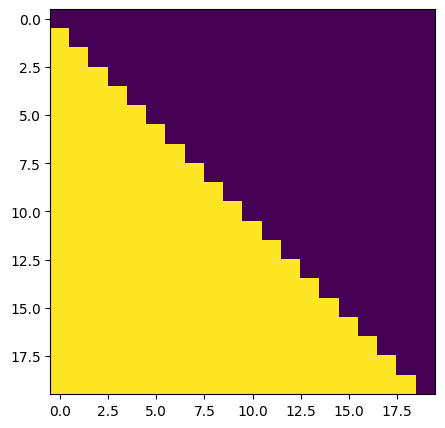

In [29]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0].cpu().numpy())

## Полная модель

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


class EncoderDecoder(nn.Module):

    def __init__(self, vocab_size,  d_model=300, d_ff=1024,
                 blocks_count=4, heads_count=10, dropout_rate=0.1, embedding=None):
        super(EncoderDecoder, self).__init__()

        self.d_model = d_model

        if embedding is not None:
          self.embedding = embedding
        else:
          self.embedding = nn.Embedding(vocab_size, d_model)

        self.d_model = d_model
        self.encoder = Encoder(self.embedding, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        self.decoder = Decoder(self.embedding, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        # self.generator = Generator(d_model, target_vocab_size)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, source_inputs, target_inputs, source_mask, target_mask, return_attn=False):
        encoder_output = self.encoder(source_inputs, source_mask, return_attn)
        decoder_output = self.decoder(target_inputs, encoder_output, source_mask, target_mask, return_attn)
        if return_attn:
            # Соберем все attention-слои
            attn_weights = {
                'encoder': self.encoder.self_attns,
                'decoder_self': [attn_weights[0] for attn_weights in self.decoder.self_attns],
                'decoder_enc': [attn_weights[1] for attn_weights in self.decoder.self_attns],
            }
            return decoder_output, attn_weights
        return decoder_output

In [31]:
def make_mask(source_inputs, target_inputs, pad_idx):
    source_mask = (source_inputs != pad_idx).unsqueeze(-2)
    target_mask = (target_inputs != pad_idx).unsqueeze(-2)
    target_mask = target_mask & subsequent_mask(target_inputs.size(-1)).type_as(target_mask)
    return source_mask, target_mask


def convert_batch(batch, pad_idx=1):
    source_inputs, target_inputs = batch.source.transpose(0, 1), batch.target.transpose(0, 1)
    source_inputs, target_inputs = batch.source.to(DEVICE).transpose(0, 1), batch.target.to(DEVICE).transpose(0, 1)
    source_inputs, target_inputs = batch.source.to(DEVICE), batch.target.to(DEVICE)
    source_mask, target_mask = make_mask(source_inputs, target_inputs, pad_idx)

    return source_inputs, target_inputs, source_mask, target_mask

In [32]:
batch = next(iter(train_iter))

In [33]:
model = EncoderDecoder(vocab_size).to(DEVICE)

out = model(*convert_batch(batch))

In [34]:
# out.shape, len(word_field.vocab)
out.shape, vocab_size

(torch.Size([16, 13, 55880]), 55880)

## Оптимизатор

Тоже очень важно в данной модели - использовать правильный оптимизатор

In [35]:
class NoamOpt(object):
    def __init__(self, model_size, factor=2, warmup=4000, optimizer=None):
        if optimizer is not None:
            self.optimizer = optimizer
        else:
            self.optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

Идея в том, чтобы повышать learning rate в течении первых warmup шагов линейно, а затем понижать его по сложной формуле:

$$
lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})
$$

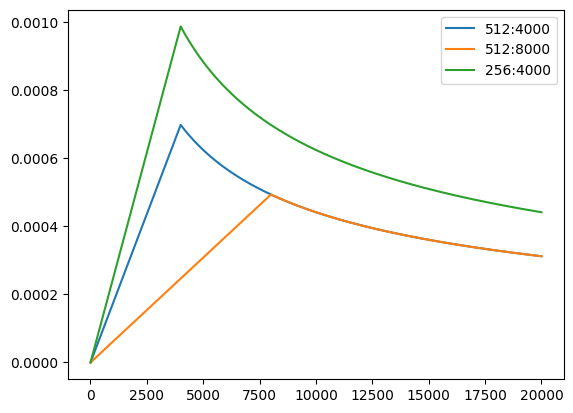

In [36]:
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## Тренировка модели

In [43]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1, padding_idx=None):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx  # индекс паддинг токена

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)

        loss = -torch.sum(true_dist * pred, dim=self.dim)

        if self.padding_idx is not None:
            mask = (target != self.padding_idx)
            loss = loss.masked_select(mask)

        return loss.mean()

In [38]:
!pip install rouge

In [39]:
from rouge import Rouge
rouge = Rouge()

def evaluate_rouge(predictions, references):
    scores = rouge.get_scores(predictions, references, avg=True)
    # for k, v in scores.items():
    #     print(f"{k}: {v}")
    return scores

def log_rouge_to_wandb(scores):
    wandb.log({
        f"{k}/{m}": v[m]
        for k, v in scores.items()
        for m in v
    })

In [ ]:
from tqdm.auto import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, optimizer=None, name=None, global_step=0):
    epoch_loss = 0

    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)

    batches_count = len(data_iter)
    global_step = 0

    all_rouge_preds = []
    all_rouge_targets = []

    

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                source_inputs, target_inputs, source_mask, target_mask = convert_batch(batch)

                logits = model.forward(source_inputs, target_inputs[:, :-1], source_mask, target_mask[:, :-1, :-1]) # потом убрать
                logits = logits.contiguous().view(-1, logits.shape[-1])  # 
                target = target_inputs[:, 1:].contiguous().view(-1) # истинные индексы токенов

                # inputs: (batch_size * seq_len, vocab_size) — вероятность каждого слова в каждом месте

                loss = criterion(logits, target)
                # print(logits)
                # print(logits.shape)
                # print(target)
                # print(target.shape)

                logits = torch.argmax(logits, dim=-1)

                # print(logits)

                predicted_words = [word_field.vocab.itos[i] for i in logits]
                target_words = [word_field.vocab.itos[i] for i in target] 

                # print(logits)

                predicted_text = ' '.join(predicted_words)
                target_text =  ' '.join(target_words)
                
                # print(predicted_text) - интересно смотреть как меняется в процессе

                rouge_scores = evaluate_rouge(predicted_text, target_text)

                all_rouge_preds.extend(predicted_text)
                all_rouge_targets.extend(target_text)

                epoch_loss += loss.item() 
                if i % 10 == 0: 
                    wandb.log({f'{name}_batch_loss': loss.item(), "step": global_step})
                    for k, v in rouge_scores.items():
                        wandb.log({f'{name}_batch_{k}': v, "step": global_step})
                    log_rouge_to_wandb(rouge_scores)    
                global_step += 1

                if optimizer:
                    optimizer.optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(),
                                                                                         math.exp(loss.item())))

            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    avg_loss = epoch_loss / batches_count
    wandb.log({f'{name}_epoch_loss': avg_loss})
    return avg_loss, global_step        


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):

    global_step=0
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, global_step = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:', global_step=global_step)
        if not val_iter is None:
            val_loss, _ = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:', global_step=global_step)

        wandb.log({
            'epoch':        epoch + 1,
            'train_loss':   train_loss,
            'val_loss':     val_loss
        }, step=global_step)

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss
        }, step=epoch + 1)

    torch.save(model.state_dict(), 'model.pt')
    wandb.save('model.pt')

    wandb.finish()

In [55]:
model = EncoderDecoder(vocab_size, embedding=embedding_layer)
model = model.to(DEVICE)

pad_idx = word_field.vocab.stoi['<pad>']
# criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE) заменили на...
pad_idx = word_field.vocab.stoi[word_field.pad_token]
criterion = LabelSmoothingLoss(vocab_size,  padding_idx=pad_idx).to(DEVICE)

optimizer = NoamOpt(model.d_model)

fit(model, criterion, optimizer, train_iter, epochs_count=30, val_iter=test_iter)

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:02<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:01<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:05<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:01<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!pip install transformers

[notice] A new release of pip is available: 23.0 -> 25.1.1

In [ ]:
class Summarizer:
    """
    Генерирует заголовок по одному тексту, используя обученный EncoderDecoder и word_field.
    """
    def __init__(self, model, word_field,
                 device=DEVICE,
                 max_len: int = 5000):
        self.model = model.to(device)
        self.field = word_field
        self.device = device
        self.max_len = max_len

        self.pad_idx = word_field.vocab.stoi[word_field.pad_token]
        self.bos_idx = word_field.vocab.stoi[word_field.init_token]
        self.eos_idx = word_field.vocab.stoi[word_field.eos_token]

        self.model.eval()

    def _encode(self, text: str) -> list[int]:

        tokens = self.field.preprocess(text)
        tokens = [self.field.init_token] + tokens + [self.field.eos_token]
        return [self.field.vocab.stoi.get(t,self.field.vocab.stoi[self.field.unk_token]) for t in tokens]

    def _decode(self, ids: list[int]) -> str:
        tokens = [self.field.vocab.itos[i] for i in ids]

        # Удалим служебные токены
        tokens = [t for t in tokens if t not in {self.field.init_token, self.field.eos_token}]

        return ' '.join(tokens)

    def predict(self, text: str, return_attn=False) -> str:
        """
        text : сырой текст статьи/новости
        return: сгенерированная сводка
        """
        src_tokens = self._encode(text)
        src_tensor = torch.tensor(src_tokens,
                                  dtype=torch.long,
                                  device=self.device).unsqueeze(0)


        generated = [self.bos_idx]

        for _ in range(self.max_len):
            tgt_tensor = torch.tensor(generated,
                                       dtype=torch.long,
                                       device=self.device).unsqueeze(0)

            src_mask, tgt_mask = make_mask(src_tensor, tgt_tensor, self.pad_idx)

            with torch.no_grad():
                if return_attn == False:
                    logits = self.model(src_tensor, tgt_tensor, src_mask, tgt_mask)
                else:
                    logits, attn = self.model(src_tensor, tgt_tensor, src_mask, tgt_mask, True)

                next_token = logits[0, -1].argmax(-1).item()

            if next_token == self.eos_idx or len(generated) > 20:
                break
            # if len(generated) > 20:
            #     break

            generated.append(next_token)

        # Декодируем обратно в строку (без <s>)
        if return_attn == False:
            return self._decode(generated[1:])
        else:
            return self._decode(generated[1:]), attn

In [ ]:
model = EncoderDecoder(vocab_size).to(DEVICE)

# 2. Загрузите веса
model.load_state_dict(torch.load('model.pt'))

# 3. Переведите модель в режим оценки (отключает dropout и т.д.)
model.eval()
summarizer = Summarizer(model, word_field)

input_text = "В международном аэропорту Гонконга автомобиль технической службы столкнулся с самолетом, на борту которого находились 295 человек. В результате пострадал водитель машины. Видео инцидента в четверг, 8 сентября, публикует издание The Daily Mail. Инцидент произошел в момент, когда лайнер ехал к взлетной полосе, чтобы направиться в малайзийский штат Пинанг. Фургон врезался в двигатель воздушного судна. В результате водитель получил травмы плеча и головы. Чтобы вызволить его из покореженного автомобиля, понадобились усилия пяти человек."
target_text = "Автомобиль протаранил пассажирский самолет в аэропорту Гонконга"

print(summarizer.field.vocab.itos[summarizer.pad_idx], summarizer.field.vocab.itos[summarizer.bos_idx], summarizer.field.vocab.itos[summarizer.eos_idx])

print(summarizer.predict(input_text))

SyntaxError: unmatched ')' (880304702.py, line 1)

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata (29 kB)
  Obtaining dependency information for torchvision from https://download.pytorch.org/whl/cu118/torchvision-0.22.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata


[notice] A new release of pip is available: 23.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata (6.3 kB)


  Obtaining dependency information for torchaudio from https://download.pytorch.org/whl/cu118/torchaudio-2.7.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata (6.8 kB)
  Obtaining dependency information for typing-extensions>=4.10.0 from https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Using cached https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Discarding https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.whl#sha256=04e5ca0351e0f3f85c6853954072df659d0d13fac324d0072316b67d7794700d (from https://download.pytorch.org/whl/cu118/typing-extensions/): Requested typing-extensions>=4.10.0 from https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.whl#sha256=04e5ca0351e0f3f85c6853954072df659d0d13fac324d0072316b67d7794700d (from torch) has inconsistent Name: expected 'typ

In [ ]:
import torch
print(torch.__version__)

2.7.0+cpu


In [ ]:
import sys
print(sys.executable)
!where python
!where pip

c:\Users\Vladlen\AppData\Local\Programs\Python\Python311\python.exe
c:\Users\Vladlen\AppData\Local\Programs\Python\Python311\python.exe
C:\msys64\mingw64\bin\python.exe
C:\Users\Vladlen\AppData\Local\Programs\Python\Python311\Scripts\pip.exe


In [ ]:
import sys
!{sys.executable} -m pip uninstall -y torch torchvision torchaudio
!{sys.executable} -m pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.5.1+cu118
Uninstalling torch-2.5.1+cu118:
  Successfully uninstalled torch-2.5.1+cu118
Found existing installation: torchvision 0.20.1+cu118
Uninstalling torchvision-0.20.1+cu118:
  Successfully uninstalled torchvision-0.20.1+cu118
Found existing installation: torchaudio 2.5.1+cu118
Uninstalling torchaudio-2.5.1+cu118:
  Successfully uninstalled torchaudio-2.5.1+cu118


In [ ]:
model = EncoderDecoder(vocab_size, pretrain_emb=True).to(DEVICE)

# 3. Переведите модель в режим оценки (отключает dropout и т.д.)
model.eval()
summarizer = Summarizer(model, _)

input_text = "В международном аэропорту Гонконга автомобиль технической службы столкнулся с самолетом, на борту которого находились 295 человек. В результате пострадал водитель машины. Видео инцидента в четверг, 8 сентября, публикует издание The Daily Mail. Инцидент произошел в момент, когда лайнер ехал к взлетной полосе, чтобы направиться в малайзийский штат Пинанг. Фургон врезался в двигатель воздушного судна. В результате водитель получил травмы плеча и головы. Чтобы вызволить его из покореженного автомобиля, понадобились усилия пяти человек."
target_text = "Автомобиль протаранил пассажирский самолет в аэропорту Гонконга"

print(summarizer.predict(input_text))

ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

In [ ]:
import seaborn as sns

def visualize_attention(input_sentence, output_sentence, attention_weights):

    attention = attention_weights.detach().cpu().numpy()

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=input_sentence, yticklabels=output_sentence, cmap='viridis')
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.title(f"Attention map {type}")
    plt.show()

In [ ]:
def attention_map(summarizer, input_text, type):
    predict, attn = summarizer.predict(input_text, True)

    print(predict)
    print(attn)

    attn = attn[type][-1][0]
    avg_attn = attn.mean(dim=0)

    if type == 'encoder':

        input_tokens = word_field.preprocess(input_text)
        input_tokens = [word_field.init_token] + input_tokens + [word_field.eos_token]

        visualize_attention(
        input_sentence=input_tokens,
        output_sentence=input_tokens,
        attention_weights=avg_attn)

    if type == 'decoder_self':

        output_tokens = word_field.preprocess(predict)
        output_tokens = [word_field.init_token] + output_tokens

        visualize_attention(
        input_sentence=output_tokens,
        output_sentence=output_tokens,
        attention_weights=avg_attn)


    if type == 'decoder_enc':

        input_tokens = word_field.preprocess(input_text)
        input_tokens = [word_field.init_token] + input_tokens + [word_field.eos_token]

        output_tokens = word_field.preprocess(predict)
        output_tokens = [word_field.init_token] + output_tokens

    visualize_attention(
        input_sentence=input_tokens,
        output_sentence=output_tokens,
        attention_weights=avg_attn,  # если батч внимания
)

C:\Users\Vladlen\AppData\Local\Temp\ipykernel_8716\2026844548.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pt'))


Соберем все attention-слои
Соберем все attention-слои
Соберем все attention-слои
Соберем все attention-слои
Соберем все attention-слои
Соберем все attention-слои
Соберем все attention-слои
Соберем все attention-слои
берегов берегов берегов мечети мечети мечети мечети
{'encoder': [tensor([[[[0.0000e+00, 1.0000e+00, 4.2760e-19,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 4.0840e-17, 1.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 1.4852e-04, 9.9985e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+

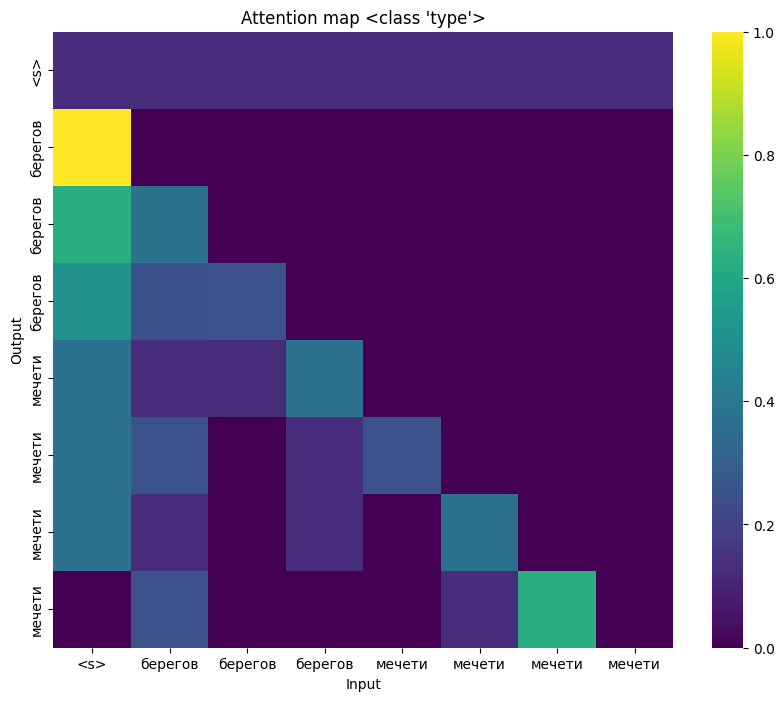

UnboundLocalError: cannot access local variable 'input_tokens' where it is not associated with a value

In [ ]:
model = EncoderDecoder(vocab_size)
model.load_state_dict(torch.load('model.pt'))
model.eval()

summarizer = Summarizer(model, word_field)
input_text = "В международном аэропорту Гонконга автомобиль технической службы столкнулся с самолетом, на борту которого находились 295 человек. В результате пострадал водитель машины. Видео инцидента в четверг, 8 сентября, публикует издание The Daily Mail. Инцидент произошел в момент, когда лайнер ехал к взлетной полосе, чтобы направиться в малайзийский штат Пинанг. Фургон врезался в двигатель воздушного судна. В результате водитель получил травмы плеча и головы. Чтобы вызволить его из покореженного автомобиля, понадобились усилия пяти человек."
attention_map(summarizer, input_text, 'decoder_self')

# Домашнее задание

## Применение модели

**Задание** Добавьте генератор суммаризации для модели.

**Задание** Добавьте оценку для модели с помощью ROUGE metric (например, из пакета https://pypi.org/project/pyrouge/0.1.3/)

**Задание** Добавьте визуализацию механизма attention (можно подсмотреть в коде по ссылкам).

## Улучшения модели

**Задание** Попробовать расшарить матрицы эмбеддингов - их тут три (входные в энкодер и декодер + выход декодера).

**Задание** Замените лосс на LabelSmoothing.

**Задание** Добавьте предодученные эмбединги.

# Дополнительные материалы

## Статьи
Attention Is All You Need, 2017 [[pdf]](https://arxiv.org/pdf/1706.03762.pdf)  
Get To The Point: Summarization with Pointer-Generator Networks, 2017 [[pdf]](https://arxiv.org/pdf/1704.04368.pdf)  
Universal Transformers, 2018 [[arxiv]](https://arxiv.org/abs/1807.03819)

## Блоги
[Transformer — новая архитектура нейросетей для работы с последовательностями](https://habr.com/post/341240/)  
[The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)  
[The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)  
[Weighted Tranformer](https://einstein.ai/research/blog/weighted-transformer)  
[Your tldr by an ai: a deep reinforced model for abstractive summarization](https://einstein.ai/research/blog/your-tldr-by-an-ai-a-deep-reinforced-model-for-abstractive-summarization)